## Domača naloga 2
### Marko Tacer, 23222087

Pri nalogi 2 smo signal generirali s pomočjo generatorja. Izmerili smo ga na priključku 2 in tudi na priključku 1, katerega meritve so brezpomenske. Definirali smo obliko signala, frekvenco in amplitudo. Določili smo tudi frekvenco vzorčenja in število meritev v posameznem zajemu. Kot vidimo spodaj so meritve kanala 2 smiselne, medtem ko so meritve na kanalu 1 sicer podobne, a brezpredmetne in neuporabne. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lvm_read
file = 'DN_signal-MT.lvm'
loaded_data = lvm_read.read(file)
data = loaded_data[0]['data'].T
N = data[0]
N1 = np.arange(0, 300)
t = data[1]
t1 = np.arange(0,0.5, 0.01)
kanal_1 = data[2]
kanal_2 = data[3]

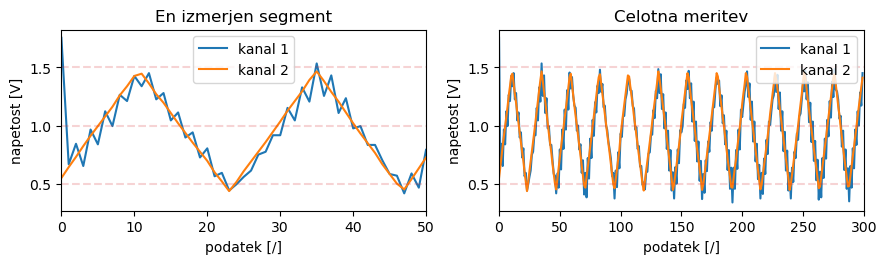

In [2]:
fig = plt.figure(figsize=(16, 8))

plt.subplot(3,3,1)
plt.gca().set_title('En izmerjen segment')
plt.plot(kanal_1, label='kanal 1')
plt.plot(kanal_2, label='kanal 2')
plt.xlabel('podatek [/]')
plt.ylabel('napetost [V]')
plt.xlim(0, 50)
plt.hlines(1, 0, 50, linestyles="dashed", color='C3', alpha=0.2)
plt.hlines(0.5, 0, 50, linestyles="dashed", color='C3', alpha=0.2)
plt.hlines(1.5, 0, 50, linestyles="dashed", color='C3', alpha=0.2)
plt.legend()

Tp = 300
plt.subplot(3,3,2)
plt.gca().set_title('Celotna meritev')
plt.plot(kanal_1, label='kanal 1')
plt.plot(kanal_2, label='kanal 2')
plt.xlabel('podatek [/]')
plt.ylabel('napetost [V]')
plt.xlim(0, Tp)
plt.hlines(1, 0, Tp, linestyles="dashed", color='C3', alpha=0.2)
plt.hlines(0.5, 0, Tp, linestyles="dashed", color='C3', alpha=0.2)
plt.hlines(1.5, 0, Tp, linestyles="dashed", color='C3', alpha=0.2)
plt.legend()

plt.show()

## Aproksimacija

Spodaj je prikazana aproksimacija na enem od zajetih segmentov. Aproksimacija je izvedena s pomočjo funkcij *InterpolatedUnivariateSpline* in *UnivariateSpline*. Prva naredi podobno, kot če pri *UnivariateSpline* definiramo faktor *"smooth"* : $s=0$. 

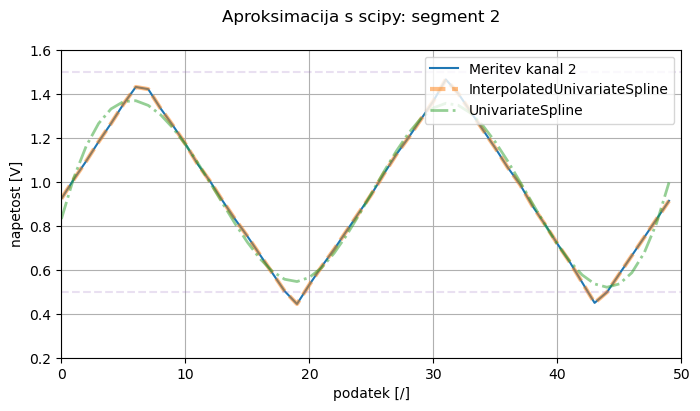

In [3]:
import scipy
i = 2
AA = 50*i 
BB = (i+1)*50         # obseg obravnavanega signala, v morem primeru i-ti segment

# https://jankoslavic.github.io/pynm/notebooks/Predavanje%2008%20-%20Aproksimacija.html#aproksimacija-s-poljubno-funkcijo

spline1 = scipy.interpolate.InterpolatedUnivariateSpline(N[AA:BB], kanal_2[AA:BB]) 
#dejansko niterpolacija, ne aproksimacija (uporabi vse točke)

spline2 = scipy.interpolate.UnivariateSpline(N[AA:BB], kanal_2[AA:BB], s=0.1) #močan faktor "smooth": s =0.1

fig = plt.figure(figsize=(8, 4))
plt.suptitle(f'Aproksimacija s scipy: segment {i}')
plt.plot(N[AA:BB], kanal_2[AA:BB], label='Meritev kanal 2')
plt.plot(N[AA:BB], spline1(N[AA:BB]), '--', alpha=0.5, lw=3, label='InterpolatedUnivariateSpline')
plt.plot(N[AA:BB], spline2(N[AA:BB]), '-.', alpha=0.5, lw=2, label='UnivariateSpline')
plt.xlabel('podatek [/]')
plt.ylabel('napetost [V]')
plt.hlines(0.5, 0, 50, linestyles="dashed", color='C4', alpha=0.2)
plt.hlines(1.5, 0, 50, linestyles="dashed", color='C4', alpha=0.2)
plt.xlim(0, 50)
plt.ylim(0.2, 1.6)
plt.legend(loc='upper right')
plt.grid(which='both')
plt.show()

## Numerično integriranje

Za numerično integracijo bom uporabili orodje *scipy.integrate.trapezoid*, kot eno izmed možnosti. Za teoretičen signal bi integral enega segmenta mojega signala moral biti enak *offset* $\cdot$ *dolžina segmenta*. V mojem primeru je to 1 $\cdot$ 0.5 = 0.5.
Dejanski zajet signal je v y-smeri zamaknjen nekoliko manj kot 1, zato je tudi izračunan integral nekoliko manj kot 0,5.

Pojavi se odstopanje na 3 decimalki, a je to ob uporabi trapezoid metode pričakovano.

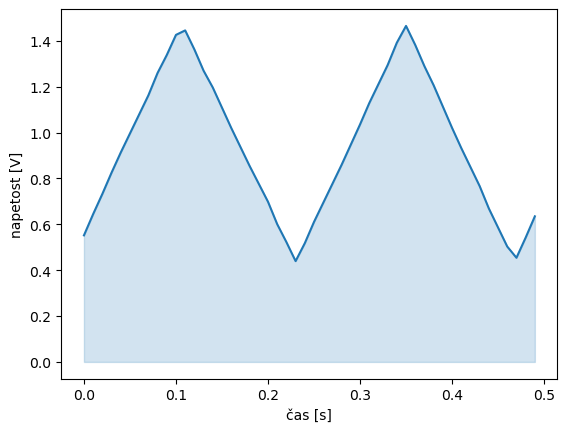

Integracija s scipy: 			 0.4644 
Integracija referenčna (teoretična): 	 0.4610 


In [4]:
i = 0
AA = 50*i 
BB = (i+1)*50 

I_trapezoid = scipy.integrate.trapezoid(kanal_2[AA:BB], dx=0.01, axis=-1)#t[AA:BB])
I_ref = np.average(kanal_2[AA:BB]) * 0.49

plt.plot(t[AA:BB], kanal_2[AA:BB])
plt.fill_between(t[AA:BB], 0, kanal_2[AA:BB], color='C0', alpha=0.2)
plt.xlabel('čas [s]')
plt.ylabel('napetost [V]')
plt.show()
print(f'Integracija s scipy: \t\t\t {I_trapezoid:.4f} ')
print(f'Integracija referenčna (teoretična): \t {I_ref:.4f} ')


## Filtriranje visokofrekvenčnega šuma

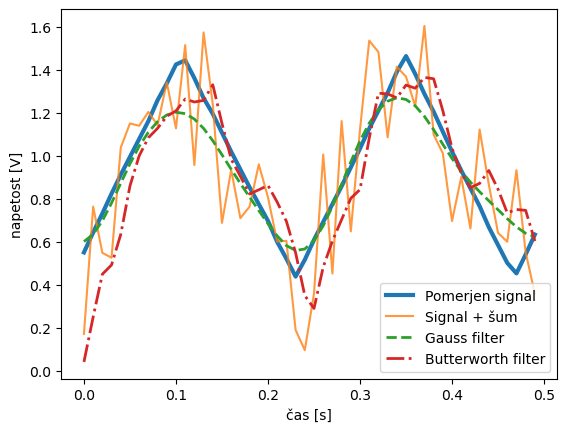

In [5]:
from scipy import signal, ndimage

kanal_2 = kanal_2[:50]
k2 = kanal_2 + 0.25 * np.random.normal(0,1,50)
t = t[:50]

trajanje = 0.5
sample_rate = 100

s1 = ndimage.gaussian_filter1d(k2, sigma=3) #sigma nam nekako definira, koliko točk okolice naj upošteva z gausovo obtežitvijo
s2 = signal.sosfilt(signal.butter(1, 10, fs=sample_rate, output='sos'), k2)
# najprej naredimo filter: naredi fade out z "jakostjo" 1 od frekvence 10Hz dalje. Vemo, da je šum višje-frekvenčni od osnovne 
# frekvence (ki je 1Hz, zato lahko filtriramo od npr.10Hz dalje)

plt.plot(t, kanal_2, lw=3, label='Pomerjen signal')
plt.plot(t, k2, label='Signal + šum', alpha=0.8)
plt.plot(t, s1, '--', lw=2, label='Gauss filter')
plt.plot(t, s2, '-.', lw=2, label='Butterworth filter')
plt.legend()
plt.xlabel('čas [s]')
plt.ylabel('napetost [V]')
plt.show()

Vidimo, da je filtracija relativno uspešna. V našem primeru je filter Gauss nekoliko boljši, a bi se s poigravanjem s parametri Butter filtra dalo drugi filter še izboljšati